# Predicting slow-selling SKUs sales

___

**1. Overview of the Dataset** <br>
**2. Feature Creation** <br>
**3. Exploration**<br>
**4. Data Cleaning**<br>
**5. Feature Engineering**<br>
**6. Modeling**<br>
**7. Individual Prophet Prediction**<br>
**8. All SKUs Prediction Using Prophet**<br>
**9. Holt-Winters Exponential Smoothing Model**<br>


___
## Overview of the Dataset
First, we import the necessary packages for this project:


In [ ]:
!pip install chart_studio
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 4.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import math
import chart_studio as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from time import time
from collections import defaultdict

#sklearn packages below:
from statsmodels.formula import api
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

import holidays
from prophet import Prophet

In [ ]:
warnings.filterwarnings('ignore')
#Ignore all warnings unless use warnings.filterwarnings(action='once')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/BestBuy Project Week/Hackathon Data_raw.csv", thousands=',')
print('Dataframe dimension:', df.shape)

Dataframe dimension: (942722, 14)


In [ ]:
df

,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,DAILY_UNITS,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,214.0,5/28/17,MISC ACCY,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,19.99,?,?,Out-of-Stock,0.0,NaN,NaN,NaN
1,329.0,5/28/17,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,?,Out-of-Stock,0.0,NaN,NaN,NaN
2,66.0,5/28/17,MIRRORLESS LENSES,LENSES,ML - ILC Cameras/Lenses,VP - Digital Imaging,399.99,?,?,Fully-Stocked,0.0,NaN,NaN,NaN
3,406.0,5/28/17,DECK HARNESS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,34.99,?,?,Out-of-Stock,0.0,NaN,NaN,NaN
4,292.0,5/28/17,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,?,Out-of-Stock,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def data_cleaning_stage_1(df):
  df = df[df['Encoded_SKU_ID'].notna()]
  df['SALES_DATE'] = pd.to_datetime(df['SALES_DATE'])
  df['year'] = pd.DatetimeIndex(df['SALES_DATE']).year
  df['month'] = pd.DatetimeIndex(df['SALES_DATE']).month
  df['DAILY_UNITS'] = df['DAILY_UNITS'].astype(float)
  df['Encoded_SKU_ID'] = df['Encoded_SKU_ID'].astype(int)
  columns_to_keep = ['Encoded_SKU_ID', 'SALES_DATE', 'SUBCLASS_NAME', 'CLASS_NAME', 'ML_NAME', 'CATEGORY_NAME', 'RETAIL_PRICE', 'PROMO_PRICE', 'COMPETITOR_PRICE', 'Inventory', 'DAILY_UNITS', 'year', 'month']
  df = df[columns_to_keep]
  return df
df = data_cleaning_stage_1(df)

Since this part is all about merging external data, we condensed them together to save space.
## Feature Creation

In [ ]:
def merge_data(df):
  # read cpi
  cpi = pd.read_csv('/content/drive/MyDrive/BestBuy Project Week/Raw data/CPIAUCSL.csv', low_memory = False, thousands=',')
  cpi['year'] = pd.DatetimeIndex(cpi['DATE']).year # extract year
  cpi['month'] = pd.DatetimeIndex(cpi['DATE']).month # extract month
  cpi_2017 = cpi[(cpi['DATE'] >= '2017-01-01') & (cpi['DATE'] < '2022-09-01')] # filtered from 2017 to 2022
  # merge df and cpi since 2017
  df2 = df.merge(cpi_2017, on=['year','month'])
  df2 = df2.drop(['DATE'], axis=1)
  # read unemployment rate
  unemployment = pd.read_csv('/content/drive/MyDrive/BestBuy Project Week/Raw data/UNRATE.csv', low_memory = False, thousands=',')
  unemployment['year'] = pd.DatetimeIndex(unemployment['DATE']).year # extract year
  unemployment['month'] = pd.DatetimeIndex(unemployment['DATE']).month # extract month
  unemployment_2017 = unemployment[(unemployment['DATE'] >= '2017-01-01') & (unemployment['DATE'] < '2022-09-01')] # filtered from 2017 to 2022
  # merge df2 and unemployment rate since 2017
  df3 = df2.merge(unemployment_2017, on=['year','month'])
  df3 = df3.drop(['DATE'], axis=1)
  # read consumer confidence index
  cci = pd.read_csv('/content/drive/MyDrive/BestBuy Project Week/Raw data/Consumer Confidence Index.csv', low_memory = False, thousands=',')
  cci['year'] = pd.DatetimeIndex(cci['TIME']).year # extract year
  cci['month'] = pd.DatetimeIndex(cci['TIME']).month # extract month
  cci_2017 = cci[(cci['TIME'] >= '2017-01-01') & (cci['TIME'] < '2022-09-01')] # filtered from 2017 to 2022
  # merge df3 and unemployment rate since 2017
  df4 = df3.merge(cci_2017, on=['year','month'])
  df4 = df4.drop(['LOCATION','INDICATOR','SUBJECT','MEASURE','FREQUENCY','TIME','Flag Codes'], axis=1)
  df4 = df4.rename(columns={"Value": "CCI"})
  df4
  # read personal consumption expenditure
  pce = pd.read_csv('/content/drive/MyDrive/BestBuy Project Week/Raw data/Personal Consumption Expenditure - Monthly.csv', low_memory = False, thousands=',')
  pce['year'] = pd.DatetimeIndex(pce['DATE']).year # extract year
  pce['month'] = pd.DatetimeIndex(pce['DATE']).month # extract month
  pce['day'] = pd.DatetimeIndex(pce['DATE']).day # extract day
  pce_2017 = pce[(pce['DATE'] >= '2017-01-01') & (pce['DATE'] < '2022-09-01')] # filtered from 2017 to 2022
  # merge df4 and unemployeement rate since 2017
  df5 = df4.merge(pce_2017, on=['year','month'])
  df5 = df5.drop(['DATE'], axis=1)
  # read global supply chain pressure index
  gscpi = pd.read_csv('/content/drive/MyDrive/BestBuy Project Week/Raw data/Global Supply Chain Pressure Index - Monthly.csv', low_memory = False, thousands=',')
  gscpi = gscpi[gscpi['GSCPI'].notna()]
  gscpi = gscpi[['Date','GSCPI']]
  gscpi['year'] = pd.DatetimeIndex(gscpi['Date']).year # extract year
  gscpi['month'] = pd.DatetimeIndex(gscpi['Date']).month # extract month
  gscpi_2017 = gscpi[(gscpi['Date'] >= '2017-01-01') & (gscpi['Date'] < '2022-09-01')] # filtered from 2017 to 2022
  # merge df4 and unemployment rate since 2017
  df6 = df5.merge(gscpi, on=['year','month'])
  df6 = df6.drop(['Date', 'day'], axis=1)
  # read consumer sentiment index
  CSI = pd.read_csv('/content/drive/MyDrive/BestBuy Project Week/Raw data/consumer sentiment index.csv', low_memory = False, thousands=',')
  df["SALES_DATE"] = pd.to_datetime(df["SALES_DATE"], format='%Y/%m/%d')
  CSI["Datemy"] = pd.to_datetime(CSI["Datemy"], format='%Y/%m/%d')
  csi_filtered = CSI.rename(columns={"Datemy": "Date", 'MONTHLY DATA': 'CSI'})[CSI['MONTHLY DATA'].notna()][['Date', 'CSI']]
  csi_filtered['year'] = pd.DatetimeIndex(csi_filtered['Date']).year # extract year
  csi_filtered['month'] = pd.DatetimeIndex(csi_filtered['Date']).month # extract month
  csi_2017 = csi_filtered[(csi_filtered['Date'] >= '2017-01-01') & (csi_filtered['Date'] < '2022-09-01')] # keep data between 2017 and 2022
  # merge df6 and consumer sentiment index table since 2017
  df = df6.merge(csi_filtered, on=['year','month'])
  df = df.drop(['Date'], axis=1)
  return df

df = merge_data(df)
df.head()

,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,DAILY_UNITS,year,month,CPIAUCSL,UNRATE,CCI,PCE,GSCPI,CSI
0,214,2017-05-28,MISC ACCY,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,19.99,?,?,Out-of-Stock,0.0,2017,5,244.004,4.4,101.2195,13117.6,-0.09,97.1
1,329,2017-05-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,?,Out-of-Stock,0.0,2017,5,244.004,4.4,101.2195,13117.6,-0.09,97.1
2,66,2017-05-28,MIRRORLESS LENSES,LENSES,ML - ILC Cameras/Lenses,VP - Digital Imaging,399.99,?,?,Fully-Stocked,0.0,2017,5,244.004,4.4,101.2195,13117.6,-0.09,97.1
3,406,2017-05-28,DECK HARNESS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,34.99,?,?,Out-of-Stock,0.0,2017,5,244.004,4.4,101.2195,13117.6,-0.09,97.1
4,292,2017-05-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,?,Out-of-Stock,0.0,2017,5,244.004,4.4,101.2195,13117.6,-0.09,97.1


In [ ]:
def feature_creation(df):
  df['day'] = pd.DatetimeIndex(df['SALES_DATE']).day
  #Import US national, state and important holidays for retail
  us_holidays = holidays.CountryHoliday('US')
  def check_holiday(date):
    if date in us_holidays:
      return 1
    else:
      return 0
  df['week'] = df['SALES_DATE'].dt.strftime("%W").astype(int) # Monday as the first day of the week
  df['Is_holiday'] = df['SALES_DATE'].apply(check_holiday)
  #Add a discount percentage feature
  condition = (df['PROMO_PRICE'] != '?')
  df['PROMO_PRICE'] = df['PROMO_PRICE'].astype(str)
  df['PROMO_PRICE'] = df['PROMO_PRICE'].apply(lambda x: x.replace(',', ''))
  df.loc[condition, 'PROMO_PRICE'] = df.loc[condition, 'PROMO_PRICE'].astype(float)

  #convert retail price from string type to float type
  df['RETAIL_PRICE'] = df['RETAIL_PRICE'].astype(str).str.replace(',','').astype(float)
  #Initialize Discount feature
  df['DISCOUNT'] = df['RETAIL_PRICE']
  df.loc[df['PROMO_PRICE'] == '?', 'DISCOUNT'] = 0.0
  df.loc[condition, 'DISCOUNT'] = 1 - df.loc[condition, 'PROMO_PRICE'] / df.loc[condition, 'RETAIL_PRICE']
  df.loc[:, 'DISCOUNT'] = df.loc[:, 'DISCOUNT'] .astype(float)
  return df

df = feature_creation(df)
df.head()

,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,...,CPIAUCSL,UNRATE,CCI,PCE,GSCPI,CSI,day,week,Is_holiday,DISCOUNT
0,214,2017-05-28,MISC ACCY,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,19.99,?,?,Out-of-Stock,...,244.004,4.4,101.2195,13117.6,-0.09,97.1,28,21,0,0.0
1,329,2017-05-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,?,Out-of-Stock,...,244.004,4.4,101.2195,13117.6,-0.09,97.1,28,21,0,0.0
2,66,2017-05-28,MIRRORLESS LENSES,LENSES,ML - ILC Cameras/Lenses,VP - Digital Imaging,399.99,?,?,Fully-Stocked,...,244.004,4.4,101.2195,13117.6,-0.09,97.1,28,21,0,0.0
3,406,2017-05-28,DECK HARNESS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,34.99,?,?,Out-of-Stock,...,244.004,4.4,101.2195,13117.6,-0.09,97.1,28,21,0,0.0
4,292,2017-05-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,?,Out-of-Stock,...,244.004,4.4,101.2195,13117.6,-0.09,97.1,28,21,0,0.0


In [ ]:
print(df.columns)
display(df.describe())
#Added holidays, used national day for test
display(df.loc[df['SALES_DATE'] == '2018-07-04',['Encoded_SKU_ID','SALES_DATE', 'Is_holiday','week']].head())

Index(['Encoded_SKU_ID', 'SALES_DATE', 'SUBCLASS_NAME', 'CLASS_NAME',
       'ML_NAME', 'CATEGORY_NAME', 'RETAIL_PRICE', 'PROMO_PRICE',
       'COMPETITOR_PRICE', 'Inventory', 'DAILY_UNITS', 'year', 'month',
       'CPIAUCSL', 'UNRATE', 'CCI', 'PCE', 'GSCPI', 'CSI', 'day', 'week',
       'Is_holiday', 'DISCOUNT'],
      dtype='object')


,Encoded_SKU_ID,RETAIL_PRICE,DAILY_UNITS,year,month,CPIAUCSL,UNRATE,CCI,PCE,GSCPI,CSI,day,week,Is_holiday,DISCOUNT
count,846632.000000,846632.000000,846632.000000,846632.000000,846632.000000,846632.000000,846632.000000,846632.00000,846632.000000,846632.000000,846632.000000,846632.000000,846632.000000,846632.000000,846632.000000
mean,272.869842,458.716598,10.532819,2019.821522,6.479617,263.212484,5.132332,99.72241,14920.426821,1.475819,83.877705,15.765934,25.925088,0.033025,0.033267
std,160.634800,786.820913,70.124984,1.443486,3.392876,13.075790,2.378753,1.66144,1253.108935,1.377852,14.135901,8.804346,14.826886,0.178702,0.087015
min,1.000000,0.010000,-4.000000,2017.000000,1.000000,244.004000,3.500000,96.03842,12082.400000,-0.650000,50.000000,1.000000,0.000000,0.000000,0.000000
25%,136.000000,16.990000,1.000000,2019.000000,4.000000,254.273000,3.700000,98.55434,14051.700000,0.380000,72.500000,8.000000,13.000000,0.000000,0.000000
50%,268.000000,64.990000,3.000000,2020.000000,6.000000,258.682000,4.000000,99.85719,14561.000000,1.090000,84.900000,16.000000,26.000000,0.000000,0.000000
75%,404.000000,599.990000,7.000000,2021.000000,9.000000,270.955000,6.100000,101.37150,15960.100000,2.670000,97.500000,23.000000,39.000000,0.000000,0.000000
max,575.000000,4829.990000,19136.000000,2022.000000,12.000000,295.328000,14.700000,101.63940,17437.400000,4.300000,101.400000,31.000000,53.000000,1.000000,0.888922


,Encoded_SKU_ID,SALES_DATE,Is_holiday,week
108786,380,2018-07-04,1,27
108787,334,2018-07-04,1,27
108788,111,2018-07-04,1,27
108789,172,2018-07-04,1,27
108790,112,2018-07-04,1,27


It is useful to examine datatypes & NaN values for each column:

In [ ]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame((df == '?').sum()).T.rename(index={0:'value is \'?\' (nb)'}))
tab_info=tab_info.append((pd.DataFrame((df == '?').sum()/df.shape[0]*100).round(2))
                         .T.rename(index={0:'Value is \'?\' (%)'}))
display(tab_info)

,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,...,CPIAUCSL,UNRATE,CCI,PCE,GSCPI,CSI,day,week,Is_holiday,DISCOUNT
column type,int64,datetime64[ns],object,object,object,object,float64,object,object,object,...,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64
value is '?' (nb),0,0,0,0,0,0,0,700478,535351,0,...,0,0,0,0,0,0,0,0,0,0
Value is '?' (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.74,63.23,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


___
## Exploration 

We want to see the distribution for quantitative variables:

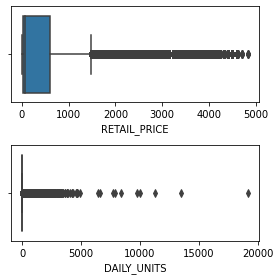

In [ ]:
fig, axs = plt.subplots(2, figsize = (4,4))
plt1 = sns.boxplot(df['RETAIL_PRICE'], ax = axs[0])
plt2 = sns.boxplot(df['DAILY_UNITS'], ax = axs[1])
plt.tight_layout()

                               Visualising Categorical Features:                                


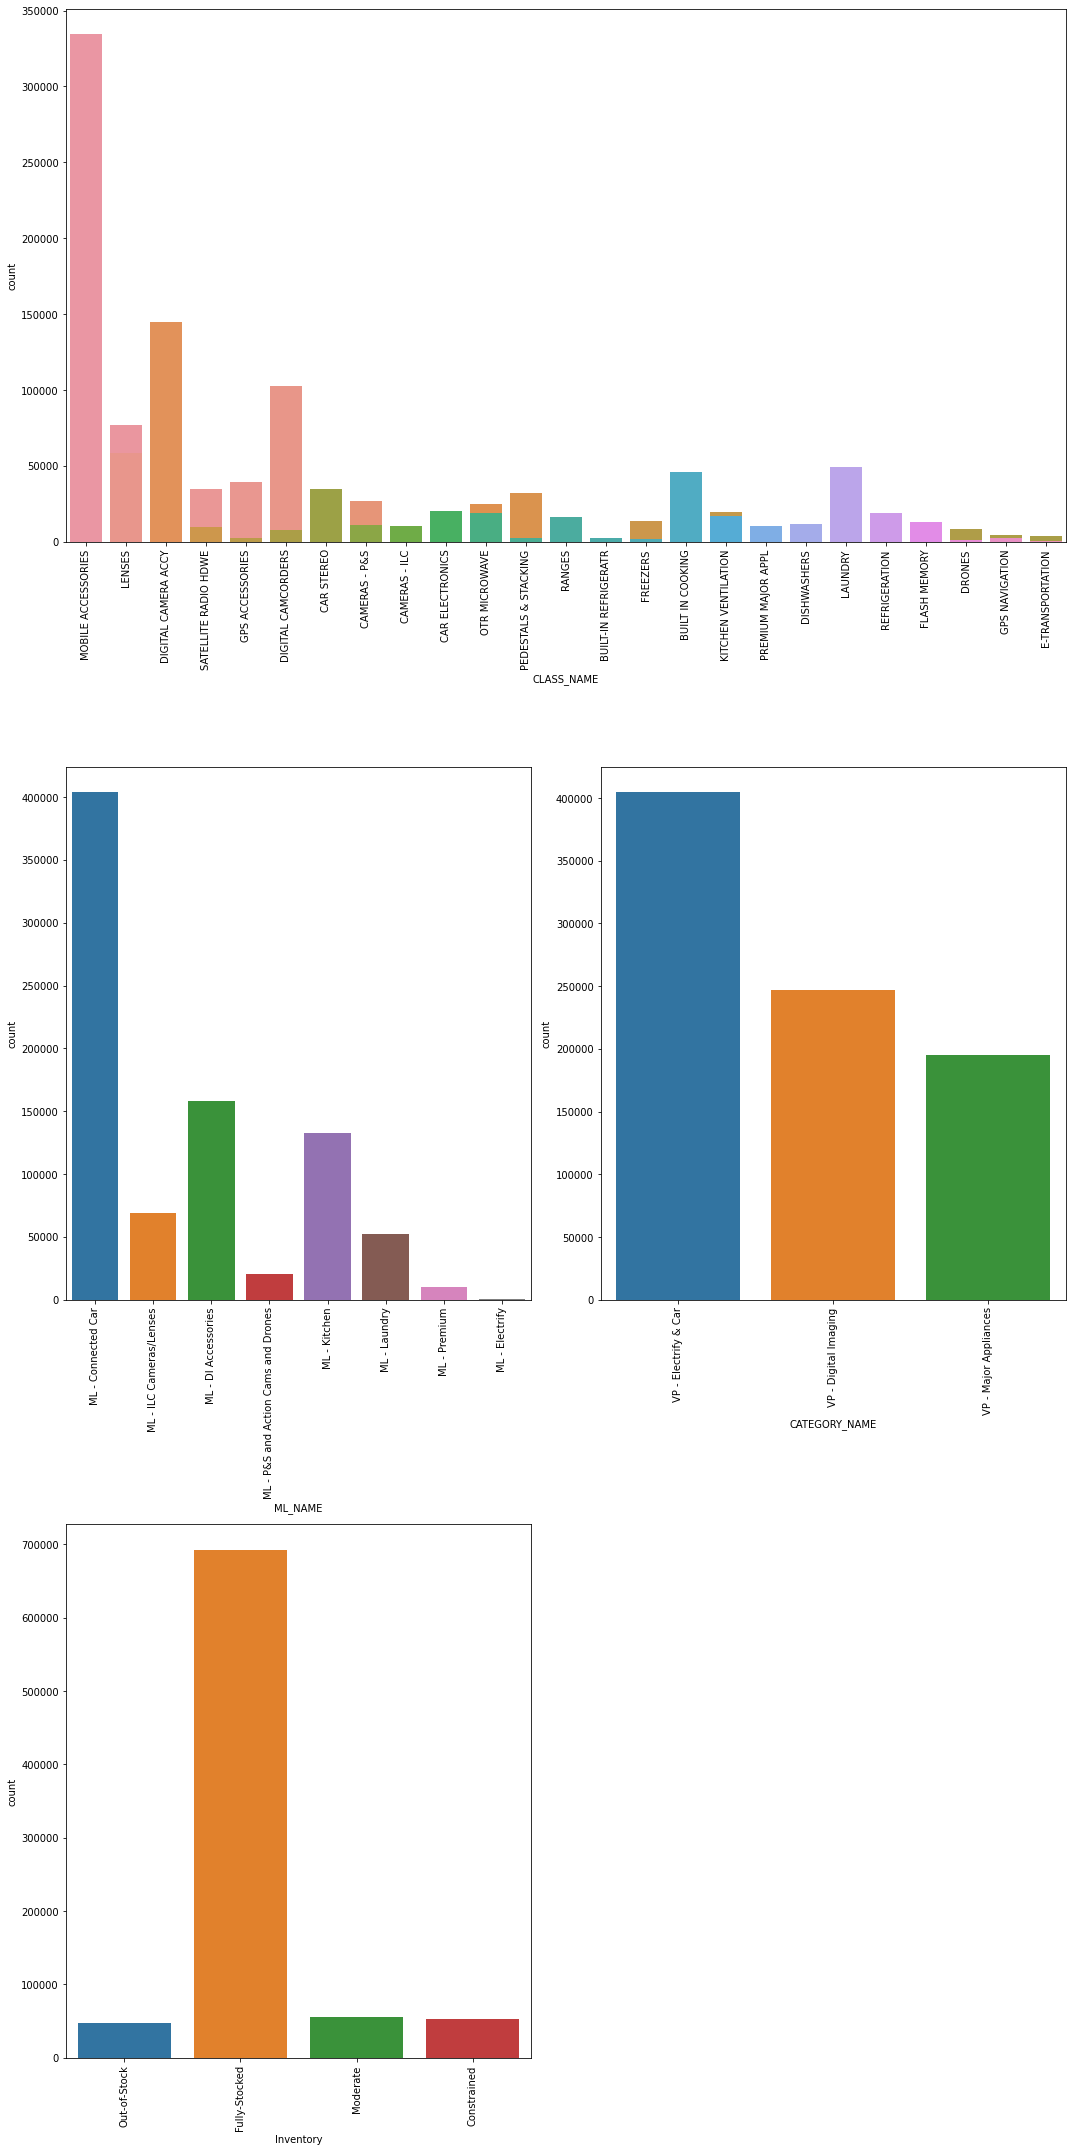

In [ ]:
cf = ['SUBCLASS_NAME', 'CLASS_NAME', 
      'ML_NAME', 'CATEGORY_NAME', 'Inventory']
print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,10*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
        plt.xticks(rotation=90)
    else:
        plt.subplot(3,1,1)
        sns.countplot(df[cf[i]])
        plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()

Text(0.5, 0, 'RETAIL_PRICE($)')

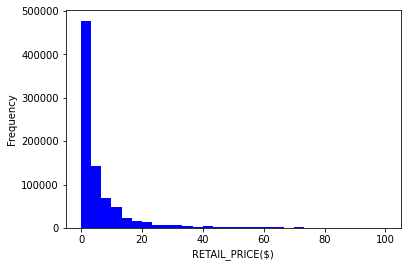

In [ ]:
#Plot the distribution of DAILY_UNITS
df_rp = df.groupby('Encoded_SKU_ID')[['Encoded_SKU_ID', 'RETAIL_PRICE']]
plt.hist(df.DAILY_UNITS, 30, range=[0, 100], facecolor='blue', align='mid')
plt.ylabel('Frequency')
plt.xlabel('RETAIL_PRICE($)') # clearly not all data follow the gaussian distribution

## Data Cleaning

Important variables to be added:
- Weekdays
- is_holiday

In [ ]:
# Subset is the range of columns we use to check for duplicates
subset = ['Encoded_SKU_ID', 'SALES_DATE', 'SUBCLASS_NAME', 'CLASS_NAME', 'ML_NAME', 
            'CATEGORY_NAME', 'RETAIL_PRICE', 'PROMO_PRICE', 'COMPETITOR_PRICE', 'Inventory', 'DAILY_UNITS']

def data_cleaning_stage_2(df):
  # To remove duplicates
  df.drop_duplicates(subset=subset, inplace=True)
  # Clean promo_price
  df['BIN_PROMO'] = (df['PROMO_PRICE'] != '?').astype(int)
  df.loc[df['PROMO_PRICE'] == '?', 'PROMO_PRICE'] = ''
  # Convert sales_date to datetime format
  df['SALES_DATE']=pd.to_datetime(df['SALES_DATE'])
  # Change weekday to binary format, 0 as weekends and 1 as weekdays
  df['weekday'] = df['SALES_DATE'].apply(lambda x: 0 if x.day_name() in ['Saturday', 'Sunday'] else 1)
  return df

df = data_cleaning_stage_2(df)
print(df.duplicated(subset=subset).value_counts())
display(df.head())
##So no duplicated values

False    846632
dtype: int64


,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,...,CCI,PCE,GSCPI,CSI,day,week,Is_holiday,DISCOUNT,BIN_PROMO,weekday
0,214,2017-05-28,MISC ACCY,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,19.99,,?,Out-of-Stock,...,101.2195,13117.6,-0.09,97.1,28,21,0,0.0,0,0
1,329,2017-05-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,,?,Out-of-Stock,...,101.2195,13117.6,-0.09,97.1,28,21,0,0.0,0,0
2,66,2017-05-28,MIRRORLESS LENSES,LENSES,ML - ILC Cameras/Lenses,VP - Digital Imaging,399.99,,?,Fully-Stocked,...,101.2195,13117.6,-0.09,97.1,28,21,0,0.0,0,0
3,406,2017-05-28,DECK HARNESS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,34.99,,?,Out-of-Stock,...,101.2195,13117.6,-0.09,97.1,28,21,0,0.0,0,0
4,292,2017-05-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,,?,Out-of-Stock,...,101.2195,13117.6,-0.09,97.1,28,21,0,0.0,0,0


In [ ]:
daily_sales = df.groupby('SALES_DATE', as_index=False)['DAILY_UNITS'].sum()
cat_daily_sales = df.groupby(['ML_NAME', 'SALES_DATE'], as_index=False)['DAILY_UNITS'].sum()
item_daily_sales = df.groupby(['Encoded_SKU_ID', 'SALES_DATE'], as_index=False)['DAILY_UNITS'].sum()

daily_sales_sc = go.Scatter(x=daily_sales['SALES_DATE'], y=daily_sales['DAILY_UNITS'])
layout = go.Layout(title='Daily sales by date', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [ ]:
cat_daily_sales_sc = []
for cat in cat_daily_sales['ML_NAME'].unique():
    current_cat_daily_sales = cat_daily_sales[(cat_daily_sales['ML_NAME'] == cat)]
    cat_daily_sales_sc.append(go.Scatter(x=cat_daily_sales['SALES_DATE'], y=current_cat_daily_sales['DAILY_UNITS'], name=('Category %s' % cat)))

layout = go.Layout(title='daily sales by Categories', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=cat_daily_sales_sc, layout=layout)
iplot(fig)

## Feature Engineering

In [ ]:
def feature_engineering(df):
  # competitor price has 63% missing data so we decide to drop it
  df.drop(columns = ['COMPETITOR_PRICE', 'SUBCLASS_NAME', 'CLASS_NAME', 'CATEGORY_NAME', 'PROMO_PRICE'], inplace= True)
  #Encode categorical variables
  mls = df["ML_NAME"]
  df = pd.get_dummies(df, columns=["Inventory", "ML_NAME"])
  df['ML_NAME'] = mls # in case that we need to run models by each group
  return df
df = feature_engineering(df)

In [ ]:
from zmq.constants import NULL
df.tail()

,Encoded_SKU_ID,SALES_DATE,RETAIL_PRICE,DAILY_UNITS,year,month,CPIAUCSL,UNRATE,CCI,PCE,...,Inventory_Out-of-Stock,ML_NAME_ML - Connected Car,ML_NAME_ML - DI Accessories,ML_NAME_ML - Electrify,ML_NAME_ML - ILC Cameras/Lenses,ML_NAME_ML - Kitchen,ML_NAME_ML - Laundry,ML_NAME_ML - P&S and Action Cams and Drones,ML_NAME_ML - Premium,ML_NAME
846627,9,2022-07-31,599.99,0.0,2022,7,295.271,3.5,96.03842,17420.3,...,1,0,0,0,0,0,0,1,0,ML - P&S and Action Cams and Drones
846628,561,2022-07-31,899.99,3.0,2022,7,295.271,3.5,96.03842,17420.3,...,0,1,0,0,0,0,0,0,0,ML - Connected Car
846629,566,2022-07-31,19.99,7.0,2022,7,295.271,3.5,96.03842,17420.3,...,0,0,1,0,0,0,0,0,0,ML - DI Accessories
846630,337,2022-07-31,16.99,1.0,2022,7,295.271,3.5,96.03842,17420.3,...,0,1,0,0,0,0,0,0,0,ML - Connected Car
846631,127,2022-07-31,4609.00,1.0,2022,7,295.271,3.5,96.03842,17420.3,...,0,0,0,0,0,0,0,0,1,ML - Premium


Encode for categorical variables

In [ ]:
df['RETAIL_PRICE'].isnull().values.any() #make sure to clear up any null retail price values

False

Use standard transformation to scale the data

In [ ]:
df.dtypes

Encoded_SKU_ID                                          int64
SALES_DATE                                     datetime64[ns]
RETAIL_PRICE                                          float64
DAILY_UNITS                                           float64
year                                                    int64
month                                                   int64
CPIAUCSL                                              float64
UNRATE                                                float64
CCI                                                   float64
PCE                                                   float64
GSCPI                                                 float64
CSI                                                   float64
day                                                     int64
week                                                    int64
Is_holiday                                              int64
DISCOUNT                                              float64
BIN_PROM

In [ ]:
features = ['RETAIL_PRICE','CPIAUCSL', 'UNRATE', 'CCI', 'PCE', 'GSCPI', 'CSI', 'DISCOUNT']
df_PCA = df[features]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(df_PCA, df['DAILY_UNITS'], train_size=0.8, test_size=0.2, random_state=100)

Apply standardization onto numeric feature data set
- we don't use normalization because of many outliers here

In [ ]:
standardized_data = StandardScaler().fit_transform(Train_X)
Train_X_std = pd.DataFrame(standardized_data, columns = features)

Text(0.5, 1.0, 'Price Distribution')

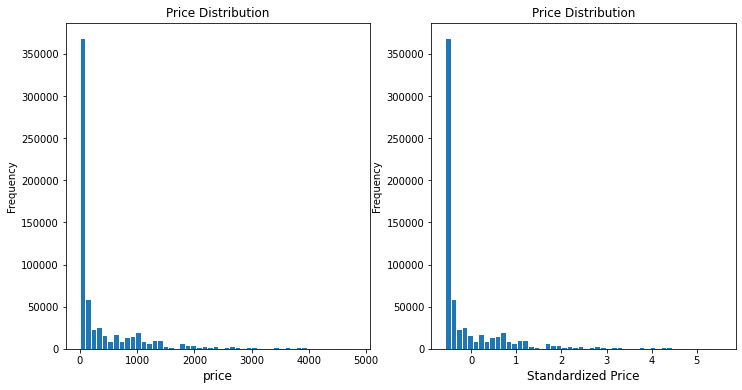

In [ ]:
plt.subplot(1, 2, 1)
(Train_X.RETAIL_PRICE).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white')
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
Train_X_std.RETAIL_PRICE.plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('Standardized Price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

Apply the log y transformation to our numeric feature data set.

In [ ]:
Train_X_log = (Train_X + 1).apply(np.log)

Text(0.5, 1.0, 'Price Distribution')

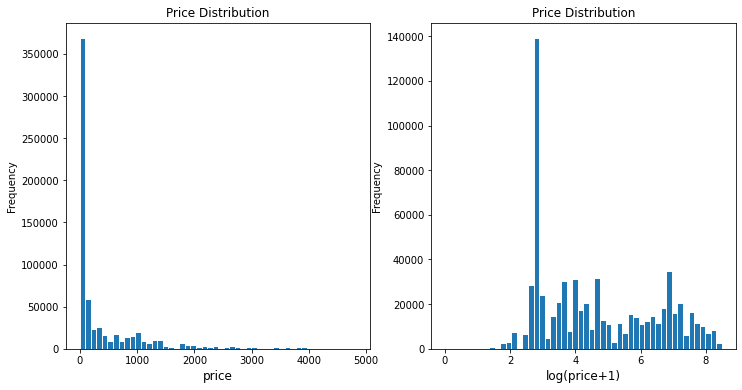

In [ ]:
plt.subplot(1, 2, 1)
(Train_X.RETAIL_PRICE).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white')
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
Train_X_log.RETAIL_PRICE.plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

- By comparing the distribution of the data before and after scaling, the histogram helps us to identify whether log transformation has a more pronounced effect on the data than the standardization does.
- Log y transformation results in a better distribution for the unit price variable.

**Apply PCA**\
Feature elimination using PCA Decomposition
Use both standardization and normalization to test which works better.

1. Determine the number of components to select \
2. Fit a random forest regressor to summarize the relative importance scores for each input of numeric features

In [ ]:
# set 98% of explained variance
pca_log = PCA(n_components = 0.98)
pca_log.fit(Train_X_log)
reduced_logy = pca_log.transform(Train_X_log)
reduced_logy

array([[ 0.33636128, -0.52867994, -0.0060777 ],
       [ 1.64680098,  1.35641858,  0.03657916],
       [ 1.09647429,  0.40935123, -0.05278287],
       ...,
       [ 0.2742155 ,  0.58808216, -0.07010617],
       [ 0.03404629,  0.29352064, -0.07528206],
       [-0.35051525, -0.53040272, -0.38618242]])

In [ ]:
# set 98% of explained variance
pca_std = PCA(n_components = 0.98)
pca_std.fit(Train_X_std)
reduced_std = pca_std.transform(Train_X_std)
reduced_std

array([[ 1.22944193, -0.3311553 , -0.54474363,  0.10583881, -0.38029078],
       [-1.91495527, -0.97421563, -0.37683831,  0.16908514,  0.47979832],
       [-2.06619208, -0.53833908, -0.5204604 ,  0.06101758, -0.12825477],
       ...,
       [-1.90229295, -0.2973197 ,  0.44234494,  1.12054852,  0.01318526],
       [-2.08023072, -0.35468252, -0.51875749, -0.03081885, -0.18772018],
       [ 4.37326637, -1.08185479, -0.22096937,  0.31784134,  1.13917411]])

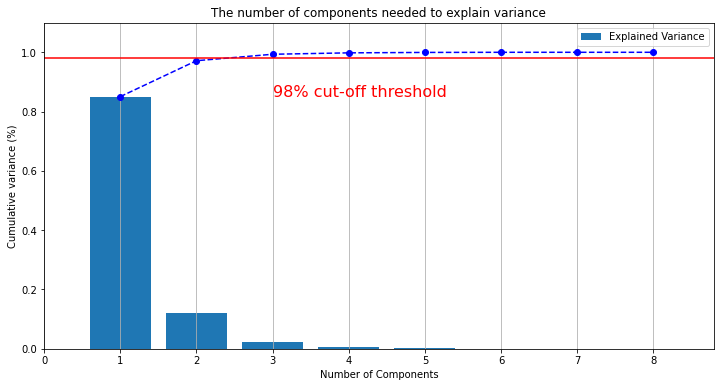

In [ ]:
pca_logy_1 = PCA().fit(Train_X_log)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
n = pca_logy_1.n_components_+1
xi = np.arange(1, n, step=1)
y = np.cumsum(pca_logy_1.explained_variance_ratio_)
ax.bar(xi, pca_logy_1.explained_variance_ratio_, lw=2, label='Explained Variance')

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, n, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.98, color='r', linestyle='-')
plt.text(3, 0.85, '98% cut-off threshold', color = 'red', fontsize=16)

plt.legend()
ax.grid(axis='x')
plt.show()

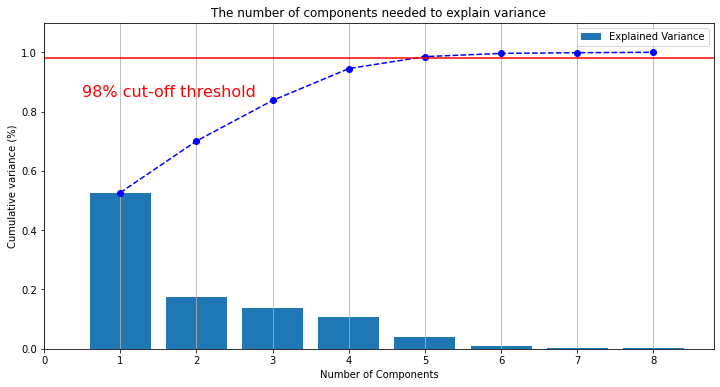

In [ ]:
pca_std_1 = PCA().fit(Train_X_std)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
n = pca_logy_1.n_components_+1
xi = np.arange(1, n, step=1)
y = np.cumsum(pca_std_1.explained_variance_ratio_)
ax.bar(xi, pca_std_1.explained_variance_ratio_, lw=2, label='Explained Variance')

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, n, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.98, color='r', linestyle='-')
plt.text(0.5, 0.85, '98% cut-off threshold', color = 'red', fontsize=16)

plt.legend()
ax.grid(axis='x')
plt.show()

- By comparing the amount of variance explained by the principal components before and after scaling, we can tell that generally the more variance explained by the principal components, the better the scaling method is considered to be. 
- The explained variance of the principal component after using log y transformation is greater than that of the principal component after applying standardization on the input data.


Apply gradient boosting method to get the importance of each independent features with a dependent feature.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
# Initialize the model
gbr = GradientBoostingRegressor(random_state=0)
# Fit the model to the data
gbr.fit(Train_X_log, Train_Y)
# Get the feature importance
importances = gbr.feature_importances_
print(importances)
print(features)

[0.16359704 0.02444722 0.04026987 0.04189796 0.01526262 0.01375247
 0.00299838 0.69777444]
['RETAIL_PRICE', 'CPIAUCSL', 'UNRATE', 'CCI', 'PCE', 'GSCPI', 'CSI', 'DISCOUNT']


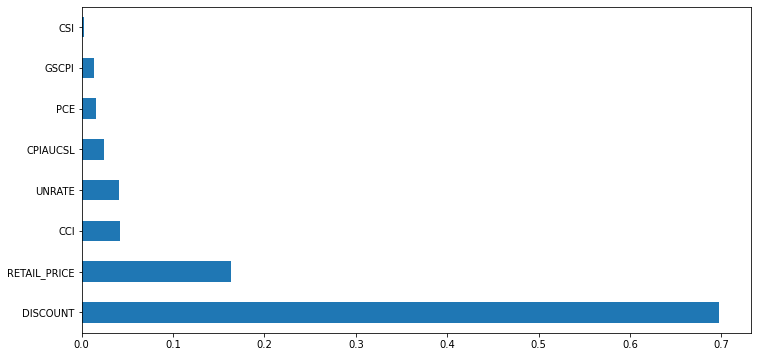

In [ ]:
feat_importances = pd.Series(gbr.feature_importances_, index =Train_X_log.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

Run random forest model on the log-y transformed data set to determine the top features to keep.

[0.48972052136746524, 0.3403162831529566, 0.06249521681781652, 0.028523602845654195, 0.02233334904439575, 0.019674966093793454, 0.01896188970723061, 0.0179741709706876]


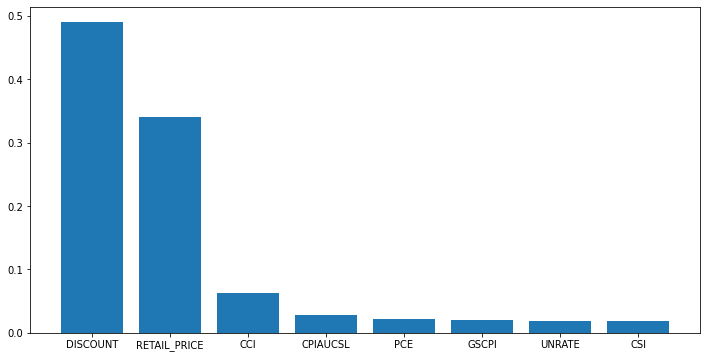

In [ ]:
from matplotlib import pyplot
# fit random forest model
model = RandomForestRegressor(n_estimators=5, random_state=1)
model.fit(Train_X_std, Train_Y)
# show importance scores
print(sorted(model.feature_importances_)[::-1])
# plot importance scores
feat_importances = pd.Series(model.feature_importances_, index =Train_X_std.columns).nlargest(8)
# names = df[features].columns.values
names = list(feat_importances.index)
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, sorted(model.feature_importances_)[::-1])
pyplot.xticks(ticks, names)
pyplot.show()

Conclusion: the importance of each one-hot encoded variable is extremely small and we can take them out from our data set.

                                       Correlation Matrix                                       


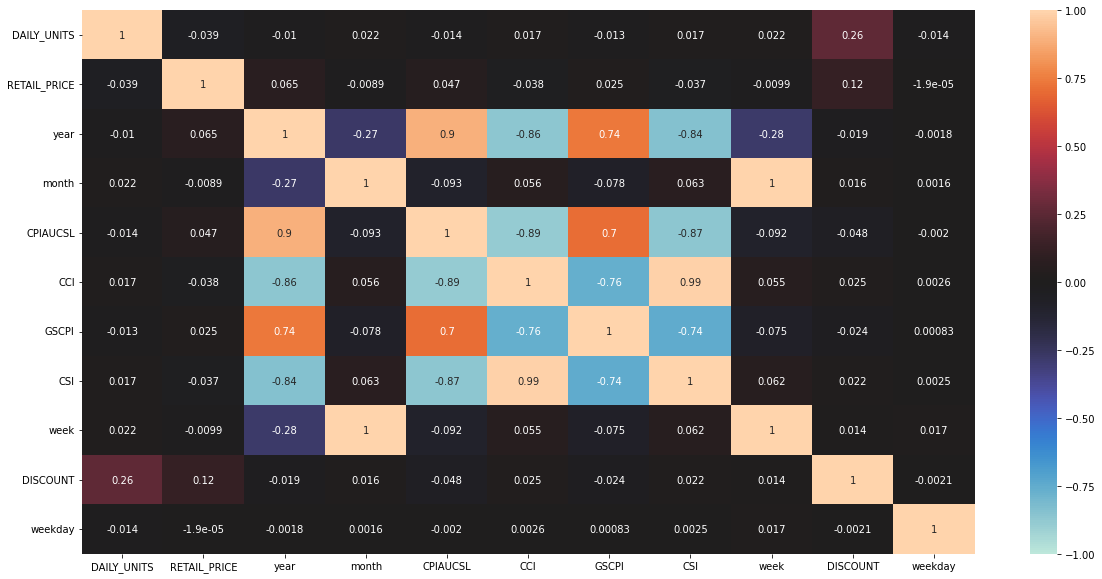

In [ ]:
# Checking for correlation between important features
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[20,10])
f_list = ['SALES_DATE','RETAIL_PRICE', 'year',
       'month', 'CPIAUCSL', 'CCI', 'GSCPI', 'CSI',
       'week', 'DISCOUNT', 'weekday']
dfcor = df[['DAILY_UNITS']+f_list]
sns.heatmap(dfcor.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

Conclusion: we decide to choose log y transformation for numeric features because it works better in PCA and it makes the distribution follows a bell curve more.

## Modeling

**Preparation**\
Using features derived from\
*RETAIL PRICE, CPI, CCI, PCE, DISCOUNT (std but choose 5)*

In [ ]:
feature_cols = ['Encoded_SKU_ID','SALES_DATE','RETAIL_PRICE', 'year',
       'month', 'CPIAUCSL', 'UNRATE', 'CCI', 'PCE', 'GSCPI', 'CSI', 'day',
       'week', 'Is_holiday', 'DISCOUNT', 'BIN_PROMO', 'weekday',
       'Inventory_Constrained', 'Inventory_Fully-Stocked',
       'Inventory_Moderate', 'Inventory_Out-of-Stock',
       'ML_NAME_ML - Connected Car', 'ML_NAME_ML - DI Accessories',
       'ML_NAME_ML - Electrify', 'ML_NAME_ML - ILC Cameras/Lenses',
       'ML_NAME_ML - Kitchen', 'ML_NAME_ML - Laundry',
       'ML_NAME_ML - P&S and Action Cams and Drones', 'ML_NAME_ML - Premium']

In [ ]:
validate_df = pd.read_csv("/content/drive/MyDrive/BestBuy Project Week/Validation_Data_raw.csv", thousands=',')
validate_df = data_cleaning_stage_1(validate_df)
validate_df = merge_data(validate_df)
validate_df = feature_creation(validate_df)
validate_df = data_cleaning_stage_2(validate_df)
validate_df = feature_engineering(validate_df)
Test_Y = validate_df[['Encoded_SKU_ID','SALES_DATE','DAILY_UNITS']].set_index(['Encoded_SKU_ID','SALES_DATE'])
validate_df.head()

,Encoded_SKU_ID,SALES_DATE,RETAIL_PRICE,DAILY_UNITS,year,month,CPIAUCSL,UNRATE,CCI,PCE,...,Inventory_Out-of-Stock,ML_NAME_ML - Connected Car,ML_NAME_ML - DI Accessories,ML_NAME_ML - Electrify,ML_NAME_ML - ILC Cameras/Lenses,ML_NAME_ML - Kitchen,ML_NAME_ML - Laundry,ML_NAME_ML - P&S and Action Cams and Drones,ML_NAME_ML - Premium,ML_NAME
0,23,2022-08-06,49.99,3.0,2022,8,295.62,3.7,96.31973,17550.9,...,0,1,0,0,0,0,0,0,0,ML - Connected Car
1,100,2022-08-02,16.99,2.0,2022,8,295.62,3.7,96.31973,17550.9,...,0,1,0,0,0,0,0,0,0,ML - Connected Car
2,121,2022-08-06,24.99,6.0,2022,8,295.62,3.7,96.31973,17550.9,...,0,1,0,0,0,0,0,0,0,ML - Connected Car
3,207,2022-08-03,499.99,0.0,2022,8,295.62,3.7,96.31973,17550.9,...,0,0,0,0,0,1,0,0,0,ML - Kitchen
4,416,2022-08-05,269.99,9.0,2022,8,295.62,3.7,96.31973,17550.9,...,0,1,0,0,0,0,0,0,0,ML - Connected Car


In [ ]:
validate_df_pro = validate_df.copy()
validate_df = validate_df[feature_cols]

In [ ]:
print(df.columns)
Train_X = df[feature_cols].loc[(df['year'] == 2022) & (df['month'].isin([5,6,7]))].set_index(['SALES_DATE','Encoded_SKU_ID'])
Train_Y = df.loc[(df['year'] == 2022) & (df['month'].isin([5,6,7]))]['DAILY_UNITS']
Test_X = validate_df.set_index(['SALES_DATE', 'Encoded_SKU_ID'])
Train_X.head()

In [ ]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 4,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }
num_boost_round = 512

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

dtrain = xgb.DMatrix(Train_X, Train_Y)
dvalid = xgb.DMatrix(Test_X, Test_Y)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

print("Train a XGBoost model")
start = time()
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=300)
end = time()
print('Training time is {:2f} s.'.format(end-start))

In [ ]:
print("validating")
yhat = gbm.predict(xgb.DMatrix(Test_X))
yhat = np.around(yhat, 0)
rmse_val = rmse(np.array(yhat), np.array(Test_Y))
print("RMSE error is: " + str(rmse_val))
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
res = pd.DataFrame(Test_Y)
res['Prediction']=yhat
display(res.head())
print(res.shape)

In [ ]:
res = pd.DataFrame(data = Test_Y)
col_1 = ['DAILY_UNITS','Prediction']
res['Prediction']=yhat
display(res.head())
res.set_index(Test_X.index, inplace = True)
res = pd.concat([Test_X, res], axis=1)#[['DAILY_UNITS','Prediction']].iloc[:,1:3]
res.to_csv('file_name.csv')
res.reset_index(level = ['Encoded_SKU_ID','SALES_DATE'], inplace = True)
display(res.head())
print(res.shape)
L=np.random.randint(low=1,high = max(res['Encoded_SKU_ID']), size = 3 ) 

NameError: ignored

## Individual Prophet Prediction

In [ ]:
df_2021 = df[(df['SALES_DATE'] >= '2021-01-01')]

df_2021_id = df_2021[df_2021['Encoded_SKU_ID']==4]
df_2021_id_2 = df_2021_id[['SALES_DATE','DAILY_UNITS']]

# to SALES_DATE
df_2021_id_2['SALES_DATE'] = pd.DatetimeIndex(df_2021_id_2['SALES_DATE'])

# from the prophet documentation every variables should have specific names
sales = df_2021_id_2.rename(columns = {'SALES_DATE': 'ds','DAILY_UNITS': 'y'})
sales.tail()

# interval_width = 0.95
# using weekly_seasonality instead of monthly or yearly
my_model = Prophet(interval_width = 0.95, weekly_seasonality=True, changepoint_prior_scale=0.5)
my_model.fit(sales)

# dataframe that extends into future 7 days 
future_dates = my_model.make_future_dataframe(periods = 7)

# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

fc = forecast[['ds', 'yhat']]

def rmse(predictions, targets):
  return np.sqrt(((predictions-targets)**2).mean())

y_actual = validate_df_pro[(validate_df_pro['SALES_DATE'].isin(fc['ds'].tail(7))) & (df['Encoded_SKU_ID']==4)][['SALES_DATE','DAILY_UNITS']]
y_predicted = fc[['ds','yhat']].tail(7)


if len(y_actual) < len(y_predicted):
  if len(y_actual) == 0:
    y_actual = y_predicted.copy()
    y_actual.rename(columns = {'ds': 'SALES_DATE', 'yhat': 'DAILY_UNITS'}, inplace=True)
    y_actual['DAILY_UNITS'] = 0
  else:
    res = y_predicted[~y_predicted.ds.isin(y_actual.SALES_DATE)]
    res['yhat'] = 0
    res.rename(columns={'ds':'SALES_DATE', 'yhat': 'DAILY_UNITS'}, inplace=True)
    y_actual = y_actual.append(res, ignore_index=True).set_index('SALES_DATE').sort_index(level=['SALES_DATE'])
if len(y_actual) == len(y_predicted):
      y_actual = y_actual.set_index('SALES_DATE').sort_index(level=['SALES_DATE'])
print(len(y_actual))
print(len(y_predicted))
y_predicted['yhat'] = np.round(y_predicted['yhat'])
rmse_val = rmse(np.array(y_predicted['yhat']), np.array(y_actual['DAILY_UNITS']))
rmse_val

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6oy21gy5/z_yk_4du.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6oy21gy5/akrrytxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41956', 'data', 'file=/tmp/tmp6oy21gy5/z_yk_4du.json', 'init=/tmp/tmp6oy21gy5/akrrytxm.json', 'output', 'file=/tmp/tmp6oy21gy5/prophet_modelvgrqvnm5/prophet_model-20230120043001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:30:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NameError: ignored

## All SKUs Prediction Using Prophet

In [ ]:
ID_list = sorted(df_2021['Encoded_SKU_ID'].unique())
rmseList = []

# this is for visualization uses
days = sorted(list(validate_df_pro['SALES_DATE'].unique()))
actual_sales_per_day = defaultdict(float)
forecast_per_day = defaultdict(float)

# get RMSE from predicting daily units during 2022 using 2021&2022 data
for id in ID_list:
  df_2021_id = df_2021[df_2021['Encoded_SKU_ID']==id]
  df_2021_id_2 = df_2021_id[['SALES_DATE','DAILY_UNITS']]

  df_2021_id_2['SALES_DATE'] = pd.DatetimeIndex(df_2021_id_2['SALES_DATE'])
  sales = df_2021_id_2.rename(columns = {'SALES_DATE': 'ds','DAILY_UNITS': 'y'})

  my_model = Prophet(interval_width = 0.95, weekly_seasonality=True, changepoint_prior_scale=0.5)
  my_model.fit(sales)

  future_dates = my_model.make_future_dataframe(periods = 7)
  forecast = my_model.predict(future_dates)

  fc = forecast[['ds', 'yhat']]

  # this is for visualization uses
  for d in days:
    val_fc = fc.loc[(fc.ds == d),'yhat'].sum()
    forecast_per_day[d] += val_fc
    val_ac = validate_df_pro[(validate_df_pro.SALES_DATE == d) & (validate_df_pro.Encoded_SKU_ID==id)].DAILY_UNITS.sum()
    actual_sales_per_day[d] += val_ac

  # they are both dataframes with columns date and units
  y_actual = validate_df_pro[(validate_df_pro['SALES_DATE'].isin(fc['ds'].tail(7))) & (validate_df_pro['Encoded_SKU_ID']==id)][['SALES_DATE','DAILY_UNITS']]
  y_predicted = fc[['ds','yhat']].tail(7)

  # in case that this product has no sales on that specific day, make y_actual as 0
  if len(y_actual) < len(y_predicted):
    if len(y_actual) == 0:
      y_actual = y_predicted.copy()
      y_actual.rename(columns = {'ds': 'SALES_DATE', 'yhat': 'DAILY_UNITS'}, inplace=True)
      y_actual['DAILY_UNITS'] = 0
    else:
      res = y_predicted[~y_predicted.ds.isin(y_actual.SALES_DATE)]
      res['yhat'] = 0
      res.rename(columns={'ds':'SALES_DATE', 'yhat': 'DAILY_UNITS'}, inplace=True)
      y_actual = y_actual.append(res, ignore_index=True).set_index('SALES_DATE').sort_index(level=['SALES_DATE'])
  if len(y_actual) == len(y_predicted):
      y_actual = y_actual.set_index('SALES_DATE').sort_index(level=['SALES_DATE'])
  rmse_val = rmse(np.array(np.round(y_predicted['yhat'])), np.array(y_actual['DAILY_UNITS']))
  
  rmseList.append(rmse_val)
  # rmse has SKU ID and RMSE

result = pd.DataFrame({'ID': ID_list, 'RMSE': np.array(rmseList)})
print(result)

# this is for visualization uses
df1 = pd.DataFrame(forecast_per_day.items(), columns = ['Day', 'Daily Forecast'])
df2 = pd.DataFrame(actual_sales_per_day.items(), columns = ['Day', 'Daily Sales'])
plot_df = df1.merge(df2, on='Day')

NameError: ignored

In [ ]:
plot_df

In [ ]:
# RMSE value for Prophet
print("RMSE VALUE: " + str(np.mean(rmseList)))
print("NUMBER OF IDs: " + str(len(rmseList)))

In [ ]:
validate_df[validate_df['SALES_DATE'] == '2022-08-06'].DAILY_UNITS.sum()

AttributeError: ignored

In [ ]:
validate_df

In [ ]:
result.RMSE.mean()

In [ ]:
y_predicted

## Holt-Winters Exponential Smoothing Model
- Based on the daily sales from the graph "daily sales by Categories", we can tell that seasonal variation is relatively unconstant for products in some categories like DI Accessories.
- Hence we use multiplicative decompositions overall.

In [ ]:
Test_Y_1 = Test_Y.reset_index().groupby('SALES_DATE').sum()
Test_Y_1

NameError: ignored

In [ ]:
df_2020 = df[df.SALES_DATE >= '07-01-2020'][['SALES_DATE','DAILY_UNITS']].groupby('SALES_DATE').sum()
df_2020.DAILY_UNITS

NameError: ignored

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import HoltWintersResults
train, test = df_2020.DAILY_UNITS, Test_Y_1.DAILY_UNITS
model = ExponentialSmoothing(np.asarray(train), seasonal='multiplicative', seasonal_periods=12)
model_fit = model.fit(optimized=True)
pred = model_fit.predict(start = len(train), end = (len(train) + 7 -1))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
print(rmse(pred[0], test))
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred, label='Holt-Winters')
plt.legend(loc='best')
plt.show()


Conclusion: 
- Daily sales have high volatility and is highly non-stationary and had multiple seasonalites. Holt-Winters Model is not the best fit model to predict.